In [1]:
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import polygons_to_bitmask
from detectron2.evaluation import inference_on_dataset, print_csv_format
from detectron2.utils import comm
setup_logger()

<Logger detectron2 (DEBUG)>

Load annotations

In [2]:
dataDir=Path('livecell-dataset/LIVECell_dataset_2021/images')
cfg = get_cfg()
register_coco_instances('sartorius_train',{}, 'livecell-dataset/livecell_annotations_train.json', dataDir)
register_coco_instances('sartorius_val',{},'livecell-dataset/livecell_annotations_val.json', dataDir)
register_coco_instances('sartorius_test',{}, 'livecell-dataset/livecell_annotations_test.json', dataDir)
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')

[12/09 19:14:32 d2.data.datasets.coco]: Loading livecell-dataset/livecell_annotations_train.json takes 14.14 seconds.
WARNING [12/09 19:14:32 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 19:14:32 d2.data.datasets.coco]: Loaded 3253 images in COCO format from livecell-dataset/livecell_annotations_train.json


### Display a sample file to check the data is loaded correctly

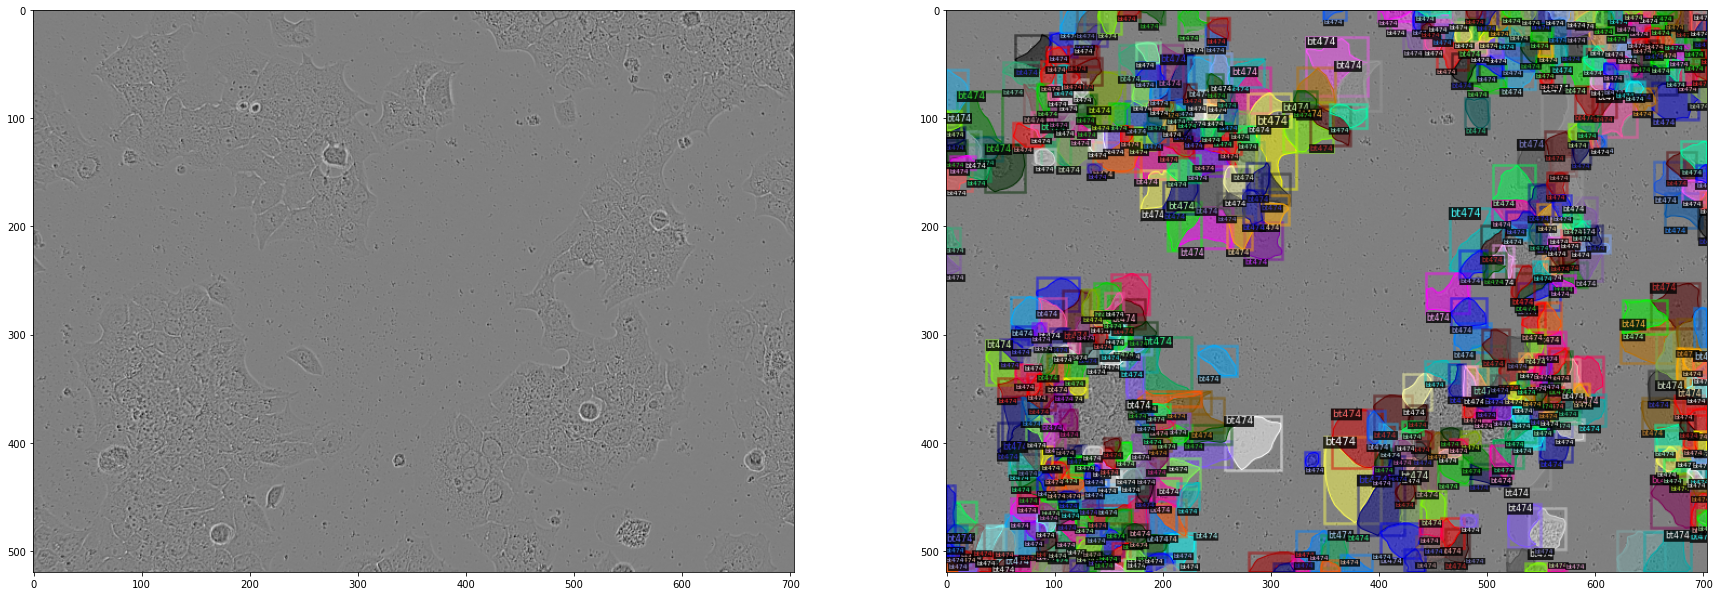

In [3]:
_, axs = plt.subplots(1, 2, figsize=(30, 20))

d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
axs[0].imshow(img)
axs[1].imshow(out.get_image()[:, :, ::-1])
plt.show()

### Define evaluator 
Generates lines like this in the training output:
`[10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311` 

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

The dataset is transformed by changing the brighness and flipping the image with 50% probability...etc

In [4]:
def polygon_to_rle(polygon, shape=(520, 704)):
    mask = polygons_to_bitmask([np.asarray(polygon) + 0.25], shape[0], shape[1])
    rle = mask_util.encode(np.asfortranarray(mask))
    return rle

# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    enc_targs = [polygon_to_rle(enc_targ[0]) for enc_targ in enc_targs]
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)
    
    def build_hooks(self):

        # copy of cfg
        cfg = self.cfg.clone()

        # build the original model hooks
        hooks = super().build_hooks()

        # add the best checkpointer hook
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                                         "MaP IoU",
                                         "max",
                                         ))
        return hooks

# Train 

Training for 42 epochs

In [ ]:
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'

# cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train", "sartorius_test")
cfg.DATASETS.TEST = ("sartorius_val",)

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
# cfg.MODEL.WEIGHTS ="../input/detectron2cell/output/model_final.pth"

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.DATALOADER.NUM_WORKERS = 8
    
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5

cfg.SOLVER.BASE_LR = 5e-3
cfg.SOLVER.GAMMA = 0.1 
#cfg.SOLVER.MOMENTUM = 0.9
#cfg.SOLVER.WEIGHT_DECAY = 0.0005

# num of epochs is MAX_ITER * IMS_PER_BATCH / TOTAL_NUM_IMAGES ~ 100000 * 2 / 4817 = 42
num_epochs = 42
epoch_len = (len(DatasetCatalog.get('sartorius_train')) + len(DatasetCatalog.get('sartorius_test'))) // cfg.SOLVER.IMS_PER_BATCH
cfg.SOLVER.STEPS = [8 * epoch_len, 35 * epoch_len]
cfg.SOLVER.CHECKPOINT_PERIOD = 7 * epoch_len
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5
cfg.TEST.EVAL_PERIOD = epoch_len

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print(cfg.OUTPUT_DIR)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/09 19:14:51 d2.data.datasets.coco]: Loading livecell-dataset/livecell_annotations_train.json takes 12.77 seconds.
WARNING [12/09 19:14:51 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 19:14:51 d2.data.datasets.coco]: Loaded 3253 images in COCO format from livecell-dataset/livecell_annotations_train.json
[12/09 19:15:04 d2.data.datasets.coco]: Loading livecell-dataset/livecell_annotations_test.json takes 7.29 seconds.
WARNING [12/09 19:15:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 19:15:04 d2.data.datasets.coco]: Loaded 1564 images in COCO format from livecell-dataset/livecell_annotations_test.json
./output
[12/09 19:15:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

[12/09 19:15:22 d2.data.datasets.coco]: Loading livecell-dataset/livecell_annotations_train.json takes 13.20 seconds.
WARNING [12/09 19:15:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 19:15:23 d2.data.datasets.coco]: Loaded 3253 images in COCO format from livecell-dataset/livecell_annotations_train.json
[12/09 19:15:35 d2.data.datasets.coco]: Loading livecell-dataset/livecell_annotations_test.json takes 7.49 seconds.
WARNING [12/09 19:15:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 19:15:35 d2.data.datasets.coco]: Loaded 1564 images in COCO format from livecell-dataset/livecell_annotations_test.json
[12/09 19:15:36 d2.data.build]: Removed 0 images with no usable annotations. 4817 images left.
[12/09 19:15:37 d2.data.build]: Distribution of instances among all 8 categories:
|  category  | #instances   |  category  | #instances   | 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (8, 256, 1, 1) 

[12/09 19:15:40 d2.engine.train_loop]: Starting training from iteration 0


/home/alex/anaconda3/envs/sartorius/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/09 19:15:44 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:15:48 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:15:52 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:15:58 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:16:03 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:16:11 d2.utils.events]:  eta: 2 days, 16:47:58  iter: 19  total_loss: 5.134  loss_cls: 2.068  loss_box_reg: 0.4131  loss_mask: 0.6933  loss_rpn_cls: 1.701  loss_rpn_loc: 0.3316  time: 1.3582  data_time: 0.1509  lr: 9.9905e-05  max_mem: 5785M
[12/09 19:16:15 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to 

[12/09 19:20:04 d2.utils.events]:  eta: 2 days, 11:13:02  iter: 199  total_loss: 2.175  loss_cls: 0.8681  loss_box_reg: 0.6017  loss_mask: 0.3555  loss_rpn_cls: 0.1573  loss_rpn_loc: 0.2342  time: 1.3000  data_time: 0.1221  lr: 0.000999  max_mem: 6498M
[12/09 19:20:04 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:20:09 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:20:14 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:20:23 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:20:30 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:20:34 d2.utils.events]:  eta: 2 days, 12:16:46  iter: 219  total_loss: 1.921  loss_cls: 0.6857  l

[12/09 19:24:38 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:24:44 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:24:48 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:24:57 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:25:00 d2.utils.events]:  eta: 2 days, 10:57:09  iter: 439  total_loss: 1.951  loss_cls: 0.6585  loss_box_reg: 0.4865  loss_mask: 0.3264  loss_rpn_cls: 0.1254  loss_rpn_loc: 0.2288  time: 1.2637  data_time: 0.0771  lr: 0.0021978  max_mem: 6699M
[12/09 19:25:01 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:25:05 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> t

[12/09 19:28:51 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:28:58 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:29:01 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:29:11 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:29:13 d2.utils.events]:  eta: 2 days, 11:12:24  iter: 639  total_loss: 1.763  loss_cls: 0.5791  loss_box_reg: 0.4775  loss_mask: 0.3038  loss_rpn_cls: 0.1506  loss_rpn_loc: 0.2278  time: 1.2648  data_time: 0.0487  lr: 0.0031968  max_mem: 6699M
[12/09 19:29:15 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:29:25 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> t

[12/09 19:33:11 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:33:15 d2.utils.events]:  eta: 2 days, 11:07:51  iter: 839  total_loss: 1.645  loss_cls: 0.548  loss_box_reg: 0.4992  loss_mask: 0.2872  loss_rpn_cls: 0.1278  loss_rpn_loc: 0.2088  time: 1.2510  data_time: 0.0429  lr: 0.0041958  max_mem: 6699M
[12/09 19:33:17 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:33:19 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:33:24 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:33:31 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:33:37 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to

[12/09 19:37:35 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:37:43 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:37:45 d2.utils.events]:  eta: 2 days, 11:17:16  iter: 1039  total_loss: 1.659  loss_cls: 0.5171  loss_box_reg: 0.475  loss_mask: 0.2829  loss_rpn_cls: 0.1158  loss_rpn_loc: 0.2086  time: 1.2703  data_time: 0.0467  lr: 0.005  max_mem: 6699M
[12/09 19:37:50 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:38:02 d2.utils.events]:  eta: 2 days, 11:16:07  iter: 1059  total_loss: 1.717  loss_cls: 0.5193  loss_box_reg: 0.4522  loss_mask: 0.2927  loss_rpn_cls: 0.1212  loss_rpn_loc: 0.2089  time: 1.2622  data_time: 0.0424  lr: 0.005  max_mem: 6699M
[12/09 19:38:05 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due

[12/09 19:41:50 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:41:55 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:42:01 d2.utils.events]:  eta: 2 days, 11:22:52  iter: 1239  total_loss: 1.657  loss_cls: 0.506  loss_box_reg: 0.4704  loss_mask: 0.2941  loss_rpn_cls: 0.1092  loss_rpn_loc: 0.1959  time: 1.2720  data_time: 0.0390  lr: 0.005  max_mem: 6699M
[12/09 19:42:02 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:42:08 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:42:11 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:42:20 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CP

[12/09 19:46:10 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:46:13 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:46:18 d2.utils.events]:  eta: 2 days, 11:32:15  iter: 1439  total_loss: 1.573  loss_cls: 0.5182  loss_box_reg: 0.4262  loss_mask: 0.2844  loss_rpn_cls: 0.1107  loss_rpn_loc: 0.2068  time: 1.2732  data_time: 0.0521  lr: 0.005  max_mem: 6933M
[12/09 19:46:24 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:46:27 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:46:29 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:46:38 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to C

[12/09 19:50:12 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:50:15 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:50:18 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:50:28 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:50:31 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:50:35 d2.utils.events]:  eta: 2 days, 11:16:44  iter: 1639  total_loss: 1.744  loss_cls: 0.5146  loss_box_reg: 0.4882  loss_mask: 0.3095  loss_rpn_cls: 0.1169  loss_rpn_loc: 0.2067  time: 1.2747  data_time: 0.0583  lr: 0.005  max_mem: 6933M
[12/09 19:50:39 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to C

[12/09 19:54:33 d2.utils.events]:  eta: 2 days, 11:13:33  iter: 1839  total_loss: 1.572  loss_cls: 0.4858  loss_box_reg: 0.4772  loss_mask: 0.2865  loss_rpn_cls: 0.1019  loss_rpn_loc: 0.2067  time: 1.2655  data_time: 0.0453  lr: 0.005  max_mem: 6933M
[12/09 19:54:41 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:54:45 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:54:51 d2.utils.events]:  eta: 2 days, 10:55:13  iter: 1859  total_loss: 1.665  loss_cls: 0.4983  loss_box_reg: 0.4786  loss_mask: 0.2808  loss_rpn_cls: 0.113  loss_rpn_loc: 0.2209  time: 1.2617  data_time: 0.0329  lr: 0.005  max_mem: 6933M
[12/09 19:54:55 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:54:59 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due

[12/09 19:59:26 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:59:36 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:59:42 d2.utils.events]:  eta: 2 days, 10:20:14  iter: 2139  total_loss: 1.488  loss_cls: 0.4212  loss_box_reg: 0.4502  loss_mask: 0.2648  loss_rpn_cls: 0.07814  loss_rpn_loc: 0.1825  time: 1.2322  data_time: 0.0392  lr: 0.005  max_mem: 6933M
[12/09 19:59:45 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:59:50 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:59:53 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 19:59:55 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to 

[12/09 20:03:43 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:03:46 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:03:49 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:03:55 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:03:59 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:04:02 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:04:06 d2.utils.events]:  eta: 2 days, 10:21:42  iter: 2359  total_loss: 1.57  loss_cls: 0.4324  loss_box_reg: 0.4338  loss_mask: 0.2786  loss_rpn_cls: 0.116  loss_rpn_loc: 0.2242  time: 1.2294  data_time: 0.0695  lr: 0.005

[12/09 20:06:59 d2.evaluation.evaluator]: Inference done 331/570. Dataloading: 0.0008 s/iter. Inference: 0.1586 s/iter. Eval: 0.1534 s/iter. Total: 0.3128 s/iter. ETA=0:01:14
[12/09 20:07:04 d2.evaluation.evaluator]: Inference done 360/570. Dataloading: 0.0008 s/iter. Inference: 0.1574 s/iter. Eval: 0.1433 s/iter. Total: 0.3015 s/iter. ETA=0:01:03
[12/09 20:07:09 d2.evaluation.evaluator]: Inference done 377/570. Dataloading: 0.0008 s/iter. Inference: 0.1577 s/iter. Eval: 0.1437 s/iter. Total: 0.3022 s/iter. ETA=0:00:58
[12/09 20:07:15 d2.evaluation.evaluator]: Inference done 394/570. Dataloading: 0.0008 s/iter. Inference: 0.1578 s/iter. Eval: 0.1435 s/iter. Total: 0.3021 s/iter. ETA=0:00:53
[12/09 20:07:20 d2.evaluation.evaluator]: Inference done 410/570. Dataloading: 0.0008 s/iter. Inference: 0.1580 s/iter. Eval: 0.1441 s/iter. Total: 0.3029 s/iter. ETA=0:00:48
[12/09 20:07:25 d2.evaluation.evaluator]: Inference done 425/570. Dataloading: 0.0008 s/iter. Inference: 0.1583 s/iter. Eval:

[12/09 20:11:04 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:11:07 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:11:09 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:11:26 d2.utils.events]:  eta: 2 days, 10:28:38  iter: 2579  total_loss: 1.603  loss_cls: 0.4719  loss_box_reg: 0.433  loss_mask: 0.3029  loss_rpn_cls: 0.131  loss_rpn_loc: 0.2309  time: 1.2251  data_time: 0.0497  lr: 0.005  max_mem: 6933M
[12/09 20:11:32 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:11:38 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:11:42 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU

[12/09 20:15:37 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:15:42 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:15:46 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:15:52 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:15:54 d2.utils.events]:  eta: 2 days, 10:28:14  iter: 2799  total_loss: 1.573  loss_cls: 0.4633  loss_box_reg: 0.4549  loss_mask: 0.287  loss_rpn_cls: 0.1123  loss_rpn_loc: 0.2039  time: 1.2246  data_time: 0.0527  lr: 0.005  max_mem: 6933M
[12/09 20:16:01 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:16:03 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CP

[12/09 20:20:03 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:20:05 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:20:11 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:20:16 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:20:22 d2.utils.events]:  eta: 2 days, 10:50:55  iter: 3019  total_loss: 1.433  loss_cls: 0.38  loss_box_reg: 0.4256  loss_mask: 0.2798  loss_rpn_cls: 0.1289  loss_rpn_loc: 0.1999  time: 1.2239  data_time: 0.0776  lr: 0.005  max_mem: 6933M
[12/09 20:20:27 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:20:37 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU

[12/09 20:24:14 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:24:21 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:24:24 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:24:26 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:24:33 d2.utils.events]:  eta: 2 days, 10:47:07  iter: 3219  total_loss: 1.365  loss_cls: 0.3636  loss_box_reg: 0.4058  loss_mask: 0.2891  loss_rpn_cls: 0.1034  loss_rpn_loc: 0.2026  time: 1.2260  data_time: 0.0637  lr: 0.005  max_mem: 6933M
[12/09 20:24:34 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:24:46 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to C

[12/09 20:28:54 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:29:01 d2.utils.events]:  eta: 2 days, 10:24:36  iter: 3439  total_loss: 1.487  loss_cls: 0.4425  loss_box_reg: 0.4347  loss_mask: 0.303  loss_rpn_cls: 0.1001  loss_rpn_loc: 0.2186  time: 1.2252  data_time: 0.0603  lr: 0.005  max_mem: 6933M
[12/09 20:29:04 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:29:19 d2.utils.events]:  eta: 2 days, 10:26:39  iter: 3459  total_loss: 1.427  loss_cls: 0.4036  loss_box_reg: 0.4351  loss_mask: 0.2783  loss_rpn_cls: 0.09824  loss_rpn_loc: 0.1884  time: 1.2234  data_time: 0.0441  lr: 0.005  max_mem: 6933M
[12/09 20:29:26 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:29:31 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU du

[12/09 20:33:47 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:33:53 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:34:00 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:34:04 d2.utils.events]:  eta: 2 days, 10:19:05  iter: 3699  total_loss: 1.471  loss_cls: 0.4031  loss_box_reg: 0.4468  loss_mask: 0.2732  loss_rpn_cls: 0.1318  loss_rpn_loc: 0.2026  time: 1.2211  data_time: 0.0458  lr: 0.005  max_mem: 6933M
[12/09 20:34:04 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:34:06 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:34:13 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to C

[12/09 20:38:06 d2.utils.events]:  eta: 2 days, 10:28:06  iter: 3899  total_loss: 1.404  loss_cls: 0.3636  loss_box_reg: 0.4401  loss_mask: 0.2533  loss_rpn_cls: 0.0928  loss_rpn_loc: 0.2043  time: 1.2205  data_time: 0.0412  lr: 0.005  max_mem: 6933M
[12/09 20:38:12 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:38:20 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:38:25 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:38:31 d2.utils.events]:  eta: 2 days, 10:24:47  iter: 3919  total_loss: 1.446  loss_cls: 0.3915  loss_box_reg: 0.4431  loss_mask: 0.2642  loss_rpn_cls: 0.08457  loss_rpn_loc: 0.1913  time: 1.2206  data_time: 0.0484  lr: 0.005  max_mem: 6933M
[12/09 20:38:43 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU d

[12/09 20:42:45 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:42:48 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:42:54 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:43:01 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:43:06 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:43:08 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:43:12 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:43:17 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0>

[12/09 20:47:13 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:47:16 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:47:21 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:47:25 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:47:29 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:47:31 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:47:38 d2.utils.events]:  eta: 2 days, 10:19:39  iter: 4359  total_loss: 1.444  loss_cls: 0.3727  loss_box_reg: 0.4301  loss_mask: 0.2905  loss_rpn_cls: 0.1044  loss_rpn_loc: 0.2251  time: 1.2229  data_time: 0.1087  lr: 0.0

[12/09 20:51:20 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:51:30 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:51:35 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:51:37 d2.utils.events]:  eta: 2 days, 10:06:18  iter: 4559  total_loss: 1.473  loss_cls: 0.3823  loss_box_reg: 0.4371  loss_mask: 0.2928  loss_rpn_cls: 0.1064  loss_rpn_loc: 0.2209  time: 1.2217  data_time: 0.0405  lr: 0.005  max_mem: 6933M
[12/09 20:51:42 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:51:47 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:51:57 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to C

[12/09 20:55:37 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:55:48 d2.utils.events]:  eta: 2 days, 10:01:53  iter: 4779  total_loss: 1.48  loss_cls: 0.3691  loss_box_reg: 0.4649  loss_mask: 0.2777  loss_rpn_cls: 0.09943  loss_rpn_loc: 0.1899  time: 1.2180  data_time: 0.0373  lr: 0.005  max_mem: 6933M
[12/09 20:55:49 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:55:51 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:56:00 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:56:04 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 20:56:09 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to C

[12/09 20:59:12 d2.evaluation.evaluator]: Inference done 496/570. Dataloading: 0.0008 s/iter. Inference: 0.1589 s/iter. Eval: 0.1391 s/iter. Total: 0.2988 s/iter. ETA=0:00:22
[12/09 20:59:17 d2.evaluation.evaluator]: Inference done 514/570. Dataloading: 0.0008 s/iter. Inference: 0.1586 s/iter. Eval: 0.1389 s/iter. Total: 0.2983 s/iter. ETA=0:00:16
[12/09 20:59:23 d2.evaluation.evaluator]: Inference done 534/570. Dataloading: 0.0008 s/iter. Inference: 0.1582 s/iter. Eval: 0.1377 s/iter. Total: 0.2967 s/iter. ETA=0:00:10
[12/09 20:59:28 d2.evaluation.evaluator]: Inference done 550/570. Dataloading: 0.0008 s/iter. Inference: 0.1579 s/iter. Eval: 0.1385 s/iter. Total: 0.2972 s/iter. ETA=0:00:05
[12/09 20:59:33 d2.evaluation.evaluator]: Inference done 567/570. Dataloading: 0.0008 s/iter. Inference: 0.1576 s/iter. Eval: 0.1388 s/iter. Total: 0.2972 s/iter. ETA=0:00:00
[12/09 20:59:33 d2.evaluation.evaluator]: Total inference time: 0:02:47.907107 (0.297181 s / iter per device, on 1 devices)
[

[12/09 21:03:13 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:03:17 d2.utils.events]:  eta: 2 days, 9:54:25  iter: 4999  total_loss: 1.466  loss_cls: 0.4218  loss_box_reg: 0.4612  loss_mask: 0.2762  loss_rpn_cls: 0.09679  loss_rpn_loc: 0.1853  time: 1.2186  data_time: 0.0702  lr: 0.005  max_mem: 6933M
[12/09 21:03:18 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:03:19 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:03:25 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:03:31 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:03:33 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to C

[12/09 21:07:39 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:07:41 d2.utils.events]:  eta: 2 days, 10:07:52  iter: 5219  total_loss: 1.384  loss_cls: 0.3648  loss_box_reg: 0.4222  loss_mask: 0.2844  loss_rpn_cls: 0.1281  loss_rpn_loc: 0.2056  time: 1.2177  data_time: 0.1088  lr: 0.005  max_mem: 6933M
[12/09 21:07:41 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:07:49 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:07:52 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:07:56 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:08:02 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to C

[12/09 21:11:30 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:11:35 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:11:41 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:11:46 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:11:51 d2.utils.events]:  eta: 2 days, 10:29:40  iter: 5399  total_loss: 1.6  loss_cls: 0.4553  loss_box_reg: 0.4417  loss_mask: 0.3055  loss_rpn_cls: 0.09909  loss_rpn_loc: 0.218  time: 1.2234  data_time: 0.0892  lr: 0.005  max_mem: 6933M
[12/09 21:11:55 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:12:04 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU

[12/09 21:16:01 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:16:04 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:16:13 d2.utils.events]:  eta: 2 days, 10:38:58  iter: 5619  total_loss: 1.273  loss_cls: 0.3346  loss_box_reg: 0.354  loss_mask: 0.2636  loss_rpn_cls: 0.1124  loss_rpn_loc: 0.1876  time: 1.2221  data_time: 0.0757  lr: 0.005  max_mem: 6933M
[12/09 21:16:17 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:16:21 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:16:31 d2.utils.events]:  eta: 2 days, 10:30:55  iter: 5639  total_loss: 1.542  loss_cls: 0.4317  loss_box_reg: 0.4687  loss_mask: 0.2858  loss_rpn_cls: 0.09293  loss_rpn_loc: 0.211  time: 1.2211  data_time: 0.0390  lr: 0.005  ma

[12/09 21:20:31 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:20:35 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:20:40 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:20:44 d2.utils.events]:  eta: 2 days, 10:52:09  iter: 5839  total_loss: 1.36  loss_cls: 0.3731  loss_box_reg: 0.4098  loss_mask: 0.2837  loss_rpn_cls: 0.08427  loss_rpn_loc: 0.1932  time: 1.2225  data_time: 0.0681  lr: 0.005  max_mem: 6933M
[12/09 21:20:50 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:20:55 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:21:02 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to C

[12/09 21:25:01 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:25:03 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:25:09 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:25:12 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:25:17 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:25:19 d2.utils.events]:  eta: 2 days, 10:34:05  iter: 6059  total_loss: 1.378  loss_cls: 0.3896  loss_box_reg: 0.4461  loss_mask: 0.2644  loss_rpn_cls: 0.08906  loss_rpn_loc: 0.1933  time: 1.2234  data_time: 0.0391  lr: 0.005  max_mem: 6933M
[12/09 21:25:19 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to 

[12/09 21:29:08 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:29:16 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:29:19 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:29:23 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:29:27 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:29:35 d2.utils.events]:  eta: 2 days, 10:22:55  iter: 6259  total_loss: 1.444  loss_cls: 0.4177  loss_box_reg: 0.4427  loss_mask: 0.2787  loss_rpn_cls: 0.106  loss_rpn_loc: 0.2093  time: 1.2252  data_time: 0.0644  lr: 0.005  max_mem: 6933M
[12/09 21:29:40 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CP

[12/09 21:33:30 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:33:36 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:33:46 d2.utils.events]:  eta: 2 days, 9:47:28  iter: 6479  total_loss: 1.402  loss_cls: 0.3709  loss_box_reg: 0.4103  loss_mask: 0.2771  loss_rpn_cls: 0.1027  loss_rpn_loc: 0.2117  time: 1.2223  data_time: 0.0518  lr: 0.005  max_mem: 6933M
[12/09 21:33:47 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:33:58 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:34:07 d2.utils.events]:  eta: 2 days, 9:53:13  iter: 6499  total_loss: 1.33  loss_cls: 0.3494  loss_box_reg: 0.4328  loss_mask: 0.2794  loss_rpn_cls: 0.09531  loss_rpn_loc: 0.1882  time: 1.2218  data_time: 0.0510  lr: 0.005  max

[12/09 21:38:05 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:38:09 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:38:15 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:38:22 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:38:25 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:38:30 d2.utils.events]:  eta: 2 days, 9:31:39  iter: 6699  total_loss: 1.355  loss_cls: 0.3648  loss_box_reg: 0.4155  loss_mask: 0.2754  loss_rpn_cls: 0.09575  loss_rpn_loc: 0.1919  time: 1.2245  data_time: 0.0541  lr: 0.005  max_mem: 6933M
[12/09 21:38:41 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to C

[12/09 21:42:34 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:42:41 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:42:44 d2.utils.events]:  eta: 2 days, 9:30:54  iter: 6899  total_loss: 1.364  loss_cls: 0.3831  loss_box_reg: 0.4198  loss_mask: 0.2574  loss_rpn_cls: 0.09126  loss_rpn_loc: 0.1902  time: 1.2259  data_time: 0.0500  lr: 0.005  max_mem: 6933M
[12/09 21:42:51 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:42:58 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:43:00 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:43:03 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to C

[12/09 21:46:57 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:47:01 d2.utils.events]:  eta: 2 days, 9:33:21  iter: 7099  total_loss: 1.317  loss_cls: 0.3698  loss_box_reg: 0.413  loss_mask: 0.2589  loss_rpn_cls: 0.07894  loss_rpn_loc: 0.1959  time: 1.2275  data_time: 0.0339  lr: 0.005  max_mem: 6933M
[12/09 21:47:03 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:47:10 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:47:19 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:47:23 d2.utils.events]:  eta: 2 days, 9:33:05  iter: 7119  total_loss: 1.318  loss_cls: 0.3411  loss_box_reg: 0.4404  loss_mask: 0.2695  loss_rpn_cls: 0.07124  loss_rpn_loc: 0.1764  time: 1.2272  data_time: 0.0459  lr: 0.005  ma

[12/09 21:50:32 d2.evaluation.evaluator]: Inference done 149/570. Dataloading: 0.0008 s/iter. Inference: 0.1558 s/iter. Eval: 0.1032 s/iter. Total: 0.2599 s/iter. ETA=0:01:49
[12/09 21:50:37 d2.evaluation.evaluator]: Inference done 164/570. Dataloading: 0.0008 s/iter. Inference: 0.1568 s/iter. Eval: 0.1122 s/iter. Total: 0.2699 s/iter. ETA=0:01:49
[12/09 21:50:43 d2.evaluation.evaluator]: Inference done 176/570. Dataloading: 0.0008 s/iter. Inference: 0.1576 s/iter. Eval: 0.1241 s/iter. Total: 0.2825 s/iter. ETA=0:01:51
[12/09 21:50:48 d2.evaluation.evaluator]: Inference done 191/570. Dataloading: 0.0008 s/iter. Inference: 0.1582 s/iter. Eval: 0.1287 s/iter. Total: 0.2878 s/iter. ETA=0:01:49
[12/09 21:50:53 d2.evaluation.evaluator]: Inference done 206/570. Dataloading: 0.0008 s/iter. Inference: 0.1588 s/iter. Eval: 0.1338 s/iter. Total: 0.2935 s/iter. ETA=0:01:46
[12/09 21:50:58 d2.evaluation.evaluator]: Inference done 220/570. Dataloading: 0.0008 s/iter. Inference: 0.1593 s/iter. Eval:

[12/09 21:54:18 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:54:20 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:54:23 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:54:28 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:54:32 d2.utils.events]:  eta: 2 days, 9:38:34  iter: 7299  total_loss: 1.409  loss_cls: 0.3795  loss_box_reg: 0.4143  loss_mask: 0.2869  loss_rpn_cls: 0.09923  loss_rpn_loc: 0.1852  time: 1.2308  data_time: 0.0899  lr: 0.005  max_mem: 6933M
[12/09 21:54:34 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:54:37 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to C

[12/09 21:58:41 d2.utils.events]:  eta: 2 days, 9:42:09  iter: 7499  total_loss: 1.253  loss_cls: 0.3226  loss_box_reg: 0.3765  loss_mask: 0.2635  loss_rpn_cls: 0.08761  loss_rpn_loc: 0.1796  time: 1.2310  data_time: 0.0494  lr: 0.005  max_mem: 6933M
[12/09 21:58:41 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:58:46 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:58:49 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:58:52 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:58:59 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 21:59:11 d2.utils.events]:  eta: 2 days, 9:43:31  iter: 7519  total_loss: 1.35  loss_cls: 0.3862  loss

[12/09 22:03:26 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:03:27 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:03:31 d2.utils.events]:  eta: 2 days, 9:48:16  iter: 7739  total_loss: 1.298  loss_cls: 0.3633  loss_box_reg: 0.4006  loss_mask: 0.2739  loss_rpn_cls: 0.1056  loss_rpn_loc: 0.1835  time: 1.2303  data_time: 0.0996  lr: 0.005  max_mem: 6933M
[12/09 22:03:32 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:03:41 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:03:51 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:03:52 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CP

[12/09 22:07:46 d2.utils.events]:  eta: 2 days, 9:40:34  iter: 7939  total_loss: 1.363  loss_cls: 0.3607  loss_box_reg: 0.4189  loss_mask: 0.261  loss_rpn_cls: 0.117  loss_rpn_loc: 0.1973  time: 1.2315  data_time: 0.0611  lr: 0.005  max_mem: 6933M
[12/09 22:07:51 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:07:55 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:08:06 d2.utils.events]:  eta: 2 days, 9:35:20  iter: 7959  total_loss: 1.298  loss_cls: 0.3366  loss_box_reg: 0.441  loss_mask: 0.2626  loss_rpn_cls: 0.05839  loss_rpn_loc: 0.1584  time: 1.2309  data_time: 0.0498  lr: 0.005  max_mem: 6933M
[12/09 22:08:09 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:08:19 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to

[12/09 22:12:36 d2.utils.events]:  eta: 2 days, 9:41:40  iter: 8199  total_loss: 1.443  loss_cls: 0.3854  loss_box_reg: 0.4387  loss_mask: 0.2774  loss_rpn_cls: 0.09656  loss_rpn_loc: 0.1924  time: 1.2278  data_time: 0.0467  lr: 0.005  max_mem: 6933M
[12/09 22:12:39 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:12:45 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:12:58 d2.utils.events]:  eta: 2 days, 9:39:34  iter: 8219  total_loss: 1.353  loss_cls: 0.3716  loss_box_reg: 0.4393  loss_mask: 0.2718  loss_rpn_cls: 0.08723  loss_rpn_loc: 0.1678  time: 1.2274  data_time: 0.0449  lr: 0.005  max_mem: 6933M
[12/09 22:13:04 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:13:13 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU du

[12/09 22:16:42 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:16:48 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:16:51 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:16:56 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:17:07 d2.utils.events]:  eta: 2 days, 9:29:07  iter: 8419  total_loss: 1.27  loss_cls: 0.3424  loss_box_reg: 0.4421  loss_mask: 0.253  loss_rpn_cls: 0.09843  loss_rpn_loc: 0.1719  time: 1.2279  data_time: 0.0676  lr: 0.005  max_mem: 6933M
[12/09 22:17:09 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:17:11 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU

[12/09 22:21:30 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:21:33 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:21:38 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:21:44 d2.utils.events]:  eta: 2 days, 9:31:31  iter: 8639  total_loss: 1.438  loss_cls: 0.3966  loss_box_reg: 0.4719  loss_mask: 0.2838  loss_rpn_cls: 0.1056  loss_rpn_loc: 0.1824  time: 1.2286  data_time: 0.0582  lr: 0.005  max_mem: 6933M
[12/09 22:21:59 d2.utils.events]:  eta: 2 days, 9:26:02  iter: 8659  total_loss: 1.373  loss_cls: 0.3645  loss_box_reg: 0.4485  loss_mask: 0.2693  loss_rpn_cls: 0.07245  loss_rpn_loc: 0.1883  time: 1.2275  data_time: 0.0331  lr: 0.005  max_mem: 6933M
[12/09 22:22:11 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due

[12/09 22:25:48 d2.utils.events]:  eta: 2 days, 9:30:44  iter: 8839  total_loss: 1.25  loss_cls: 0.3227  loss_box_reg: 0.4016  loss_mask: 0.2517  loss_rpn_cls: 0.06645  loss_rpn_loc: 0.1705  time: 1.2285  data_time: 0.0440  lr: 0.005  max_mem: 6933M
[12/09 22:25:52 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:25:56 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:25:59 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:26:12 d2.utils.events]:  eta: 2 days, 9:35:50  iter: 8859  total_loss: 1.241  loss_cls: 0.31  loss_box_reg: 0.3934  loss_mask: 0.2605  loss_rpn_cls: 0.08796  loss_rpn_loc: 0.181  time: 1.2284  data_time: 0.0608  lr: 0.005  max_mem: 6933M
[12/09 22:26:15 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to

[12/09 22:30:15 d2.utils.events]:  eta: 2 days, 9:29:56  iter: 9059  total_loss: 1.379  loss_cls: 0.3908  loss_box_reg: 0.3718  loss_mask: 0.2783  loss_rpn_cls: 0.1118  loss_rpn_loc: 0.214  time: 1.2281  data_time: 0.0536  lr: 0.005  max_mem: 6933M
[12/09 22:30:17 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:30:20 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:30:29 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:30:39 d2.utils.events]:  eta: 2 days, 9:31:58  iter: 9079  total_loss: 1.301  loss_cls: 0.3612  loss_box_reg: 0.3896  loss_mask: 0.2634  loss_rpn_cls: 0.1013  loss_rpn_loc: 0.1841  time: 1.2280  data_time: 0.0479  lr: 0.005  max_mem: 6933M
[12/09 22:30:47 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due t

[12/09 22:34:58 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:35:12 d2.utils.events]:  eta: 2 days, 9:30:01  iter: 9299  total_loss: 1.27  loss_cls: 0.3334  loss_box_reg: 0.4438  loss_mask: 0.2704  loss_rpn_cls: 0.1036  loss_rpn_loc: 0.1817  time: 1.2283  data_time: 0.0395  lr: 0.005  max_mem: 6933M
[12/09 22:35:13 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:35:17 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:35:19 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:35:21 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:35:32 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU

[12/09 22:39:30 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:39:34 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:39:38 d2.utils.events]:  eta: 2 days, 8:55:53  iter: 9519  total_loss: 1.362  loss_cls: 0.396  loss_box_reg: 0.4182  loss_mask: 0.262  loss_rpn_cls: 0.07616  loss_rpn_loc: 0.1717  time: 1.2278  data_time: 0.0461  lr: 0.005  max_mem: 6933M
[12/09 22:39:40 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:39:47 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:39:54 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:39:58 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU

[12/09 22:43:08 d2.evaluation.evaluator]: Inference done 169/570. Dataloading: 0.0008 s/iter. Inference: 0.1689 s/iter. Eval: 0.1267 s/iter. Total: 0.2965 s/iter. ETA=0:01:58
[12/09 22:43:13 d2.evaluation.evaluator]: Inference done 182/570. Dataloading: 0.0008 s/iter. Inference: 0.1691 s/iter. Eval: 0.1342 s/iter. Total: 0.3041 s/iter. ETA=0:01:58
[12/09 22:43:18 d2.evaluation.evaluator]: Inference done 197/570. Dataloading: 0.0008 s/iter. Inference: 0.1692 s/iter. Eval: 0.1370 s/iter. Total: 0.3071 s/iter. ETA=0:01:54
[12/09 22:43:24 d2.evaluation.evaluator]: Inference done 210/570. Dataloading: 0.0008 s/iter. Inference: 0.1692 s/iter. Eval: 0.1431 s/iter. Total: 0.3132 s/iter. ETA=0:01:52
[12/09 22:43:29 d2.evaluation.evaluator]: Inference done 225/570. Dataloading: 0.0008 s/iter. Inference: 0.1691 s/iter. Eval: 0.1467 s/iter. Total: 0.3166 s/iter. ETA=0:01:49
[12/09 22:43:34 d2.evaluation.evaluator]: Inference done 235/570. Dataloading: 0.0008 s/iter. Inference: 0.1689 s/iter. Eval:

[12/09 22:47:03 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:47:08 d2.utils.events]:  eta: 2 days, 9:14:51  iter: 9719  total_loss: 1.259  loss_cls: 0.3492  loss_box_reg: 0.4261  loss_mask: 0.2667  loss_rpn_cls: 0.09127  loss_rpn_loc: 0.1864  time: 1.2295  data_time: 0.0823  lr: 0.005  max_mem: 6933M
[12/09 22:47:10 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:47:26 d2.utils.events]:  eta: 2 days, 9:17:46  iter: 9739  total_loss: 1.321  loss_cls: 0.3652  loss_box_reg: 0.4146  loss_mask: 0.2587  loss_rpn_cls: 0.06424  loss_rpn_loc: 0.1745  time: 1.2288  data_time: 0.0366  lr: 0.005  max_mem: 6933M
[12/09 22:47:33 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:47:35 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU du

[12/09 22:51:25 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:51:29 d2.utils.events]:  eta: 2 days, 9:37:55  iter: 9939  total_loss: 1.354  loss_cls: 0.3572  loss_box_reg: 0.4289  loss_mask: 0.2678  loss_rpn_cls: 0.1064  loss_rpn_loc: 0.1761  time: 1.2285  data_time: 0.0632  lr: 0.005  max_mem: 6933M
[12/09 22:51:31 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:51:37 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:51:40 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:51:47 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:51:51 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CP

[12/09 22:55:54 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:56:00 d2.utils.events]:  eta: 2 days, 9:37:02  iter: 10159  total_loss: 1.193  loss_cls: 0.3302  loss_box_reg: 0.3559  loss_mask: 0.2465  loss_rpn_cls: 0.06697  loss_rpn_loc: 0.1711  time: 1.2286  data_time: 0.0483  lr: 0.005  max_mem: 6933M
[12/09 22:56:00 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:56:18 d2.utils.events]:  eta: 2 days, 9:36:59  iter: 10179  total_loss: 1.246  loss_cls: 0.3307  loss_box_reg: 0.3968  loss_mask: 0.2608  loss_rpn_cls: 0.06113  loss_rpn_loc: 0.1662  time: 1.2279  data_time: 0.0366  lr: 0.005  max_mem: 6933M
[12/09 22:56:23 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 22:56:38 d2.utils.events]:  eta: 2 days, 9:35:46  iter: 10199  total_loss: 1.318  loss_cls: 0.3729  loss_

[12/09 23:00:35 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 23:00:44 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 23:00:47 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 23:00:54 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 23:00:59 d2.utils.events]:  eta: 2 days, 10:19:35  iter: 10399  total_loss: 1.436  loss_cls: 0.3766  loss_box_reg: 0.4484  loss_mask: 0.2839  loss_rpn_cls: 0.09628  loss_rpn_loc: 0.2005  time: 1.2289  data_time: 0.0839  lr: 0.005  max_mem: 6933M
[12/09 23:01:04 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f63ee3c09d0> to CPU due to CUDA OOM
[12/09 23:01:17 d2.utils.events]:  eta: 2 days, 10:24:15  iter: 10419  total_loss: 1.381  loss_cls: 0.3738 